In [ ]:
import numpy as np
import pandas as pd
import pickle
import torch.nn as nn
from torch.utils.data import DataLoader
import json
import plotly.express as px

#Implement training process
from model_trees_algebra import NeoRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class BaoTrainingException(Exception):
    pass

URL = "/workspace/TreeConvolution/DS_WIKIDATA_TESIS/"

def split_ds(all_data, val_rate, seed):
    """
    Used  to keep a balance of sets with respect to runtime of queries. 
    test_rate is a rate of the total,
    val_rate is a rate of the (total - test_rate)
    :param all_data: Pandas dataframe with data
    :param val_rate: Rate of the (total - test_rate)
    :param seed: For replication of results, this fixes the seed of split method. 
    :return: 
    """
    ranges = {}
    ranges['1_2'] = all_data[(all_data["time"] > 0)    & (all_data["time"] <= 2)]
    ranges['2_3'] = all_data[(all_data["time"] > 2)    & (all_data["time"] <= 3)]
    ranges['3_4'] = all_data[(all_data["time"] > 3)    & (all_data["time"] <= 4)]
    ranges['4_5'] = all_data[(all_data["time"] > 4)    & (all_data["time"] <= 5)]
    ranges['5_8'] = all_data[(all_data["time"] > 5)    & (all_data["time"] <= 8)]
    ranges['8_10'] = all_data[(all_data["time"] > 8)   & (all_data["time"] <= 10)]
    ranges['10_20'] =   all_data[(all_data["time"] > 10) & (all_data["time"] <= 20)]
    ranges['20_30'] =   all_data[(all_data["time"] > 20) & (all_data["time"] <= 30)]
    ranges['30_40'] =   all_data[(all_data["time"] > 30) & (all_data["time"] <= 40)]
    ranges['40_50'] =   all_data[(all_data["time"] > 40) & (all_data["time"] <= 50)]
    ranges['50_60'] =   all_data[(all_data["time"] > 50) & (all_data["time"] <= 60)]
    ranges['60_80'] =   all_data[(all_data["time"] > 60) & (all_data["time"] <= 80)]
    ranges['80_100'] =  all_data[(all_data["time"] > 80) & (all_data["time"] <= 100)]
    ranges['100_150'] = all_data[(all_data["time"] > 100) & (all_data["time"] <= 150)]
    ranges['150_200'] = all_data[(all_data["time"] > 150) & (all_data["time"] <= 200)]
    ranges['200_250'] = all_data[(all_data["time"] > 200) & (all_data["time"] <= 250)]
    ranges['250_last'] = all_data[(all_data["time"] > 250)]
    train_data = []
    val_data = []
    for rang in ranges.values():
        if rang.shape[0] >= 3:
            X_train, X_val = train_test_split(
                rang, test_size=val_rate, shuffle=True,random_state=seed)

            train_data.append(X_train)
            val_data.append(X_val)
    train_data_list = pd.concat(train_data)
    val_data_list = pd.concat(val_data)
    print("Shapes : Train: {} Val: {}".format(train_data_list.shape, val_data_list.shape))
    return train_data_list, val_data_list

ds_test = pd.read_csv(URL + "ds_test_pred_filtered.csv", delimiter="ᶶ", engine='python')
data_train_val = pd.read_csv(URL + "ds_trainval_pred_filtered.csv", delimiter="ᶶ", engine='python')

data_train_val = data_train_val[data_train_val['time'] <=65]
ds_test = ds_test[ds_test['time'] <=65]

print("Shape: train_val data" , data_train_val.shape)
def clear_error_tuples(x):
    try:
        json.loads(x)
        return True
    except:
        print("Error in data ignored!", x)
        return False

#Split Dataset
ds_train, ds_val = split_ds(data_train_val, 0.2,seed=None)
#Remove bad rows
ds_train  = ds_train[ds_train['trees'].apply(lambda x: clear_error_tuples(x))]
ds_val  = ds_val[ds_val['trees'].apply(lambda x: clear_error_tuples(x))]
ds_test  = ds_test[ds_test['trees'].apply(lambda x: clear_error_tuples(x))]

In [ ]:

def getpredictions_info(x_val_tree, x_val_query, y_val):
    """
    Get statistics by a set of data. Need the previous trained model(availablre  form reg object).
    :param x_val_tree: Plan level features.
    :param x_val_query: Query level features.
    :param y_val: Real execution time
    :return: Dict with predictions and metrics (mae, rmse, mse)
    """
    Xt, Xq, Yv = reg.json_loads(x_val_tree, x_val_query.values, y_val)
    Xt = [reg.fix_tree(x) for x in Xt]
    Xt = reg.tree_transform.transform(Xt)

    pairs_val = list(zip(list(zip(Xt, Xq)), Yv))
    dataset_val = DataLoader(pairs_val, batch_size=64, num_workers=0, shuffle=False, collate_fn=reg.collate_with_card)
    results_val = reg.predict_best(dataset_val)
    y_pred_val, y_real_val = zip(*results_val)
    mseval = mean_squared_error(y_real_val, y_pred_val)
    maeval = mean_absolute_error(y_real_val, y_pred_val)
    rmseval = np.sqrt(mseval)
    return {"pred": y_pred_val, "real" : y_real_val, "mse": mseval, "mae": maeval, "rmse": rmseval, "history": reg.history}

def getmax(x):
    lista=  list(x.values())
    maximo = 0
    for el in lista:
        if (maximo < float(el)):
            maximo = float(el)
    return maximo

def pred2index_dict(x, pred_to_index, maxcardinality):
    """
    get histogram from cardinality features. the values is normalized using the max cardinality of predicate in dataset.
    :param x: Tree data from x row sample.
    :param pred_to_index: dict with predicates and their index.
    :param maxcardinality: Max cardiniality in the dataset.
    :return: dictionary with feature json_cardinality.
    """
    resp = {}
    x = json.loads(x)
    for el in x.keys():
        if el in pred_to_index:
            resp[pred_to_index[el]] = float(x[el])/maxcardinality
    return resp

def prepare_query_level_data(x_train_query, x_val_query, x_test_query):
    """ Apply StandardScaller to columns except for json_cardinality that need other proccess"""
    maxcardinality =  x_train_query['json_cardinality'].apply(lambda x: json.loads(x)).apply(lambda x: getmax(x)).max()
    #Scale x_query data.
    xqtrain = x_train_query.drop(columns=['json_cardinality'])
    xqval   = x_val_query.drop(columns=['json_cardinality'])
    xqtest   = x_test_query.drop(columns=['json_cardinality'])

    scalerx = StandardScaler()
    x_train_scaled = scalerx.fit_transform(xqtrain)
    x_val_scaled = scalerx.transform(xqval)
    x_test_scaled = scalerx.transform(xqtest)

    x_train_query =pd.concat([pd.DataFrame(x_train_scaled, index=xqtrain.index, columns=xqtrain.columns),x_train_query[['json_cardinality']]], axis=1)
    x_val_query =  pd.concat([pd.DataFrame(x_val_scaled,   index=xqval.index, columns=xqval.columns),x_val_query[['json_cardinality']]], axis=1)
    x_test_query =  pd.concat([pd.DataFrame(x_test_scaled,   index=xqtest.index, columns=xqtest.columns),x_test_query[['json_cardinality']]], axis=1)

    x_train_query['json_cardinality'] = x_train_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(),maxcardinality))
    x_val_query['json_cardinality'] = x_val_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(), maxcardinality))
    x_test_query['json_cardinality'] = x_test_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(), maxcardinality))

    return x_train_query, x_val_query, x_test_query


### TreeConv Neural Net

Size Train: 17352, Val 4345
Model optimizer: Adam lr: 0.00015
Trees tranformed!!!
X_train loaded
X_val loaded
Transforming Trees
Initial input channels of tree model: None
Activation function in treeConv layers: <class 'torch.nn.modules.activation.LeakyReLU'>
Activation function in tree dense output layers: <class 'torch.nn.modules.activation.ReLU'>
[BinaryTreeConvWithQData(
  (weights): Conv1d(2112, 512, kernel_size=(3,), stride=(3,))
), TreeLayerNorm(), TreeActivation(
  (activation): LeakyReLU(negative_slope=0.01)
), BinaryTreeConv(
  (weights): Conv1d(512, 256, kernel_size=(3,), stride=(3,))
), TreeLayerNorm(), TreeActivation(
  (activation): LeakyReLU(negative_slope=0.01)
), BinaryTreeConv(
  (weights): Conv1d(256, 128, kernel_size=(3,), stride=(3,))
), TreeLayerNorm(), TreeActivation(
  (activation): LeakyReLU(negative_slope=0.01)
), DynamicPooling(), Linear(in_features=128, out_features=64, bias=True), ReLU(), Linear(in_features=64, out_features=32, bias=True), ReLU(), Linear(in

AttributeError: 'NeoRegression' object has no attribute 'get_'

<Figure size 432x288 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

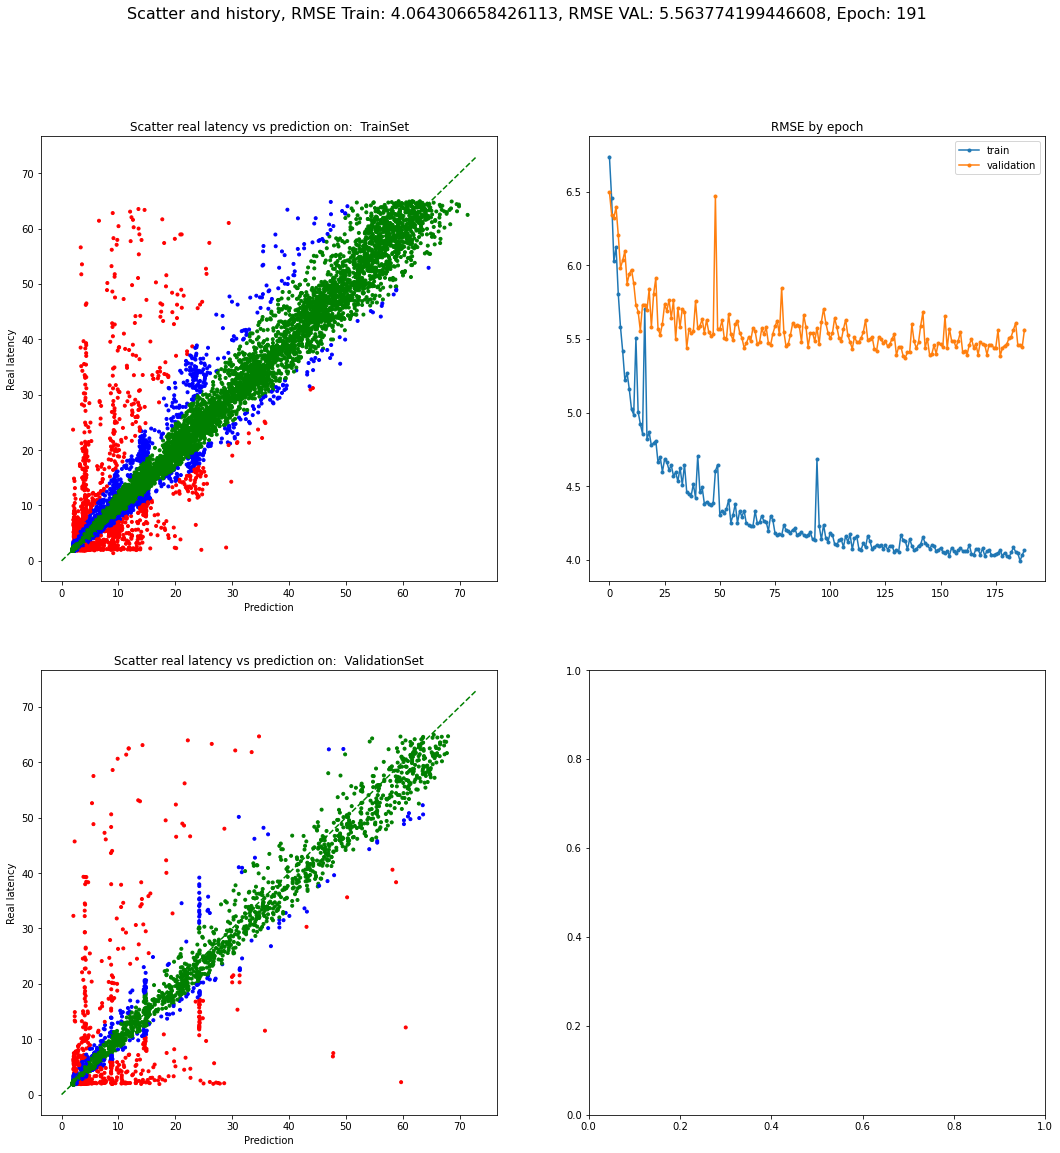

In [3]:
# Columns to use.
list_columns = ['assign', 'bgp', 'distinct', 'extend', 'filter', 'graph', 'group',
'join', 'leftjoin','minus', 'multi', 'notoneof', 'order', 'path*',  'project', 'reduced',
'sequence', 'slice', 'tolist', 'top','treesize', 'triple', 'union' ,
'path+', 'path?', 'pathN*', 'pathN+', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4',
'pcs5', 'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11','pcs12', 'pcs13',
'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23', 'pcs24',
                'filter_bound', 'filter_contains', 'filter_eq', 'filter_exists',
       'filter_ge', 'filter_gt', 'filter_isBlank', 'filter_isIRI',
       'filter_isLiteral', 'filter_lang', 'filter_langMatches', 'filter_le',
       'filter_lt', 'filter_ne', 'filter_not', 'filter_notexists', 'filter_or',
       'filter_regex', 'filter_sameTerm', 'filter_str', 'filter_strends',
       'filter_strstarts', 'filter_subtract', 'has_slice', 'max_slice_limit', 'max_slice_start','json_cardinality']
folds_execution = {}

print("Size Train: {}, Val {}".format(ds_train.shape[0], ds_val.shape[0]))

# get query level data
x_train_query = ds_train[list_columns]
x_val_query   = ds_val[list_columns]

# get plan level data
x_train_tree = ds_train['trees'].values
x_val_tree = ds_val['trees'].values

y_train = ds_train['time'].values
y_val = ds_val['time'].values

x_test_tree = ds_test['trees'].values
y_test = ds_test['time'].values
x_test_query   = ds_test[list_columns]


aec_dir = ''
maxcardinality =  x_train_query['json_cardinality'].apply(lambda x: json.loads(x)).apply(lambda x: getmax(x)).max()

verbose=True
reg = NeoRegression(
     aec={'train_aec': False, 'use_aec': True,'aec_file': '', 'aec_epochs': 200},
     epochs=400,
     maxcardinality=maxcardinality,
     in_channels_neo_net=512,
     tree_units=[512, 256, 128],
     tree_units_dense=[64, 32],
     early_stop_patience=10,
     early_stop_initial_patience=180,
     tree_activation_tree=nn.LeakyReLU,
     tree_activation_dense=nn.ReLU,
    optimizer={'optimizer': "Adam",'args':{"lr":0.00015}},
    figimage_size=(18,18),
    start_history_from_epoch=3
)

#Fit the transformer tree data
reg.fit_transform_tree_data(ds_train, ds_val, ds_test)
print("Trees tranformed!!!")

x_train_query, x_val_query, x_test_query =  prepare_query_level_data(x_train_query, x_val_query, x_test_query)

#Fit model
reg.fit(x_train_tree, x_train_query.values, y_train, x_val_tree, x_val_query.values, y_val)

#Save best model
import torch
torch.save(reg.best_model.state_dict(), "./best_model.pt")
#Save stats in val set
file_to_store = open("./execution_model_stats.pickle", "wb")
pickle.dump(getpredictions_info(x_val_tree, x_val_query, y_val), file_to_store)
file_to_store.close()

In [ ]:

val_stats = getpredictions_info(x_val_tree, x_val_query, y_val)

In [90]:
ds_val['y_pred'] = val_stats['pred']

In [15]:

test_stats = getpredictions_info(x_test_tree, x_test_query, y_test)

In [25]:
ds_test['y_realcheck'] = test_stats['real']


In [84]:
def tag_points(x):
    """Add quality tags of predictions. Used to plot with plotly"""
    difference = x['time'] - x['y_pred'][0]
    abs_diff = np.abs(difference)
    x['y_pred'] = x['y_pred'][0]
    x['query2'] = x['query'].replace(" . ", ' . <br>').replace(" FILTER", '<br> FILTER').replace(" { ", ' { <br>').replace(" } ", ' <br> }').replace(" ; ", ' ; <br>') 
    p20 = x['time'] * 0.2
    p40 = x['time'] * 0.4
    if abs_diff < p20:
        x['color'] = "good prediction"
    elif abs_diff < p40:
        x['color'] = "aceptable prediction"
    else:
        x['color'] = "bad prediction"
    return x

In [86]:
other = ds_test.apply(lambda x: tag_points(x), axis=1)

In [93]:
other.to_pickle("./predictions_test.pickle")

In [91]:
otherval = ds_val.apply(lambda x: tag_points(x), axis=1)

In [94]:
otherval.to_pickle("./predictions_val.pickle")

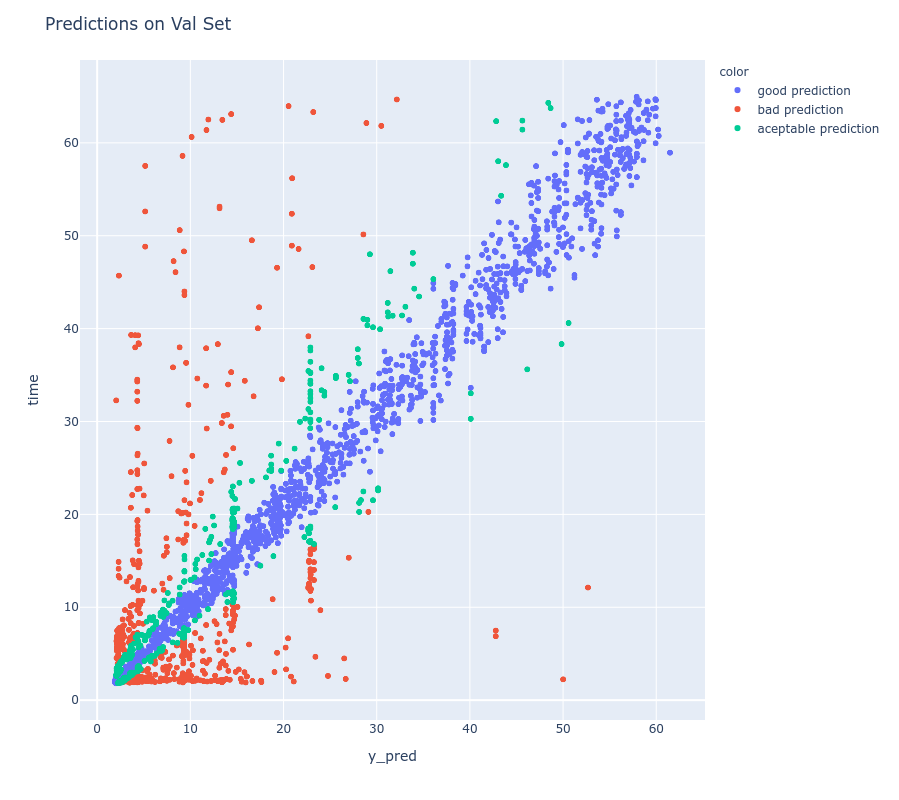

In [92]:
fig = px.scatter(otherval[['id','query','query2','time','y_pred','color']], x="y_pred", y="time", color="color", hover_data=['id', 'query2'])
fig.update_layout(height=800, width=1000, title_text="Predictions on Val Set")
fig.show()

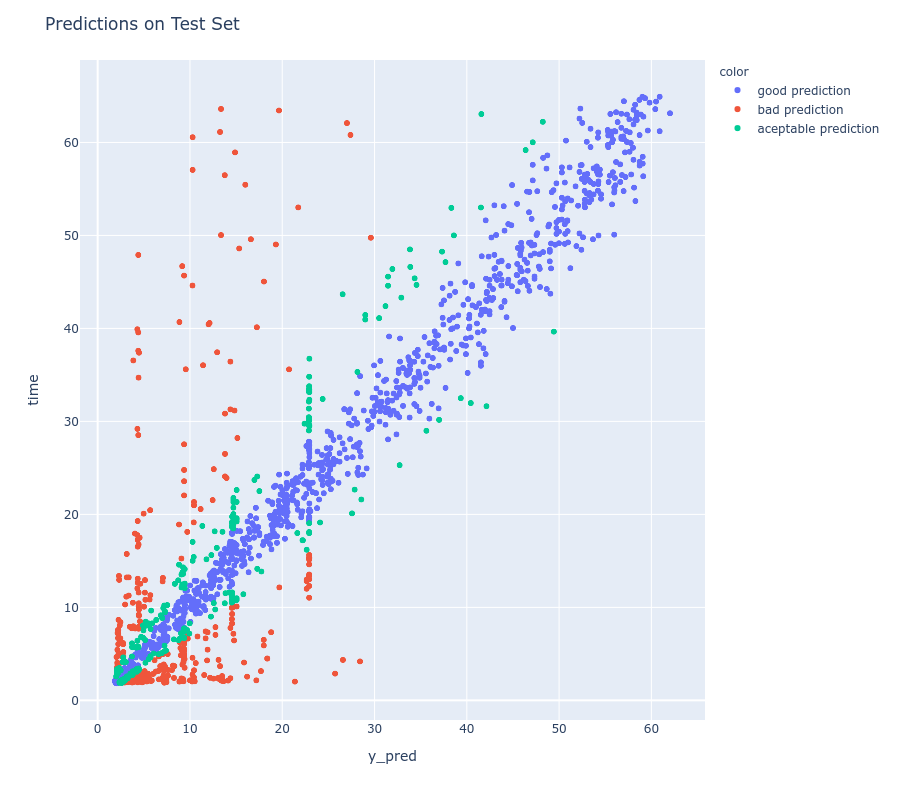

In [87]:
fig = px.scatter(other[['id','query','query2','time','y_pred','color']], x="y_pred", y="time", color="color", hover_data=['id', 'query2'])
fig.update_layout(height=800, width=1000, title_text="Predictions on Test Set")
fig.show()